<hr style="border:2px solid gray">

#**STEP: 1/5** - Review previous Code-Along, and wrangle both train and test data.


### Import libraries and define the data path

In [1]:
# import the necessary libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from itertools import compress

In [2]:
%%capture

!pip install category_encoders==2.*
from category_encoders import OneHotEncoder

In [3]:
#Update the DATA_PATH variable

import sys

if 'google.colab' in sys.modules:
  # If you're on Colab:
  DATA_PATH = 'https://raw.githubusercontent.com/bloominstituteoftechnology/ds_code_along_unit_2/main/data/flight/'
else:
  # If you're working locally:
  DATA_PATH = '..../data/'

### Wrangle the dataset

In [15]:
def wrangle(filepath):

  # read datetime information
  df = pd.read_excel(filepath, parse_dates=['Date_of_Journey'], index_col='Date_of_Journey', date_format='%d/%m/%Y')

  # Drop row(s) where there is/are missing values
  df.dropna(inplace = True)

  # Duration is in a string format. Converting duration into minutes.
  df['Duration'] = df['Duration'].apply(convert_duration)

  # formatting the stops. 'non-stop' output is replaced by 0 in the Total_Stops,
  # and the rest of the values would be filled in by the number of stops

  df['Total_Stops'] = df['Total_Stops'].str.split(" ").str[0]
  df['Total_Stops'] = df['Total_Stops'].replace('non-stop' , 0)

  # Converting the stops dtype to int
  df['Total_Stops'] = df["Total_Stops"].astype(int)

  # drop the columns that are no longer needed
  df.drop(columns=['Route', 'Dep_Time', 'Arrival_Time'], inplace=True)


  return df

def convert_duration(duration):
    if len(duration.split()) == 2:
        hours = int(duration.split()[0][:-1])
        minutes = int(duration.split()[1][:-1])
        return hours * 60 + minutes
    else:
        return int(duration[:-1]) * 60

# wrangle both your train and test set in exactly the same way

df = wrangle(DATA_PATH + 'Data_Train.xlsx')
X_test = wrangle(DATA_PATH + 'Test_set.xlsx')

In [16]:
#what is the shape of these two dataset?

df.shape, X_test.shape

((10682, 7), (2671, 6))

In [33]:
df.head()

,Airline,Source,Destination,Duration,Total_Stops,Additional_Info,Price
Date_of_Journey,,,,,,,
2019-03-24,IndiGo,Banglore,New Delhi,170,0,No info,3897
2019-05-01,Air India,Kolkata,Banglore,445,2,No info,7662
2019-06-09,Jet Airways,Delhi,Cochin,1140,2,No info,13882
2019-05-12,IndiGo,Kolkata,Banglore,325,1,No info,6218
2019-03-01,IndiGo,Banglore,New Delhi,285,1,No info,13302


In [31]:
X_test.head()

,Airline,Source,Destination,Duration,Total_Stops,Additional_Info
Date_of_Journey,,,,,,
2019-06-06,Jet Airways,Delhi,Cochin,655,1,No info
2019-05-12,IndiGo,Kolkata,Banglore,240,1,No info
2019-05-21,Jet Airways,Delhi,Cochin,1425,1,In-flight meal not included
2019-05-21,Multiple carriers,Delhi,Cochin,780,1,No info
2019-06-24,Air Asia,Banglore,Delhi,170,0,No info


<hr style="border:2px solid gray">

#**STEP: 2/5** - Improve Wrangle Function



In [19]:
# determine the number of unique values in all the remaining columns.
for col in df:
  print(col, ':', df[col].nunique())

Airline : 12
Source : 5
Destination : 6
Duration : 367
Total_Stops : 5
Additional_Info : 10
Price : 1870


In [ ]:
# inside the wrangle function, drop the columns that are high cardinal or cause data redundancy. Add to the inside the wrangle function
# df.drop(columns=['Route', 'Dep_Time', 'Arrival_Time'], inplace=True)

In [ ]:
# modify the read_csv in wrangle function to account for datatime information
# df = pd.read_excel(filepath, parse_dates=['Date_of_Journey'], index_col='Date_of_Journey')

In [21]:
# do we have any null values?

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10682 entries, 2019-03-24 to 2019-05-09
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10682 non-null  object
 1   Source           10682 non-null  object
 2   Destination      10682 non-null  object
 3   Duration         10682 non-null  int64 
 4   Total_Stops      10682 non-null  int64 
 5   Additional_Info  10682 non-null  object
 6   Price            10682 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 667.6+ KB


<hr style="border:2px solid gray">

#**STEP: 3/5** - Split Data and determine a baseline


In [22]:
# Split the data into Feature Matrix and Target Vector

target = 'Price'
y = df[target]
X = df.drop(columns=target)

In [34]:
X.index.min(), X.index.max()

(Timestamp('2019-03-01 00:00:00'), Timestamp('2019-06-27 00:00:00'))

In [35]:
# Split data into Train and Validation sets. What should be our cut-off and mask?
# (Use data from Jan to Aug 2019 as Training Set. Use data from Sept to Dec 2019 as Validation Set.)

cutoff = '2019-06-01'
mask = X.index < cutoff

X_train, y_train = X.loc[mask], y.loc[mask]
X_val, y_val = X.loc[~mask], y.loc[~mask]

In [36]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((7268, 6), (7268,), (3414, 6), (3414,))

In [37]:
# Determine the baseline for our regression task

y_pred_baseline = [y_train.mean()] * len(y_train)
print('BASELINE MAE', mean_absolute_error(y_train,y_pred_baseline))

BASELINE MAE 3859.7569907093434


<hr style="border:2px solid gray">

#**STEP: 4/5** - Implement a univariate feature selection process and build Ridge model pipeline


In [38]:
# Build Ridge model pipeline

model_ridge = make_pipeline(
    OneHotEncoder(use_cat_names=True), # handle categorical features
    StandardScaler(), # scale numerical features
    SelectKBest(score_func=f_regression), # select important features
    Ridge() # train a ridge regression model
)

model_ridge.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Airline', 'Source', 'Destination',
                                     'Additional_Info'],
                               use_cat_names=True)),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x7b95ca373ba0>)),
                ('ridge', Ridge())])

<hr style="border:2px solid gray">

#**STEP: 5/5** - Model Interpretation


In [39]:
# Evaluate the model performance and compare it to the baseline

print('Ridge training MAE:', mean_absolute_error(y_train, model_ridge.predict(X_train)))
print('Ridge validation MAE:', mean_absolute_error(y_val, model_ridge.predict(X_val)))

Ridge training MAE: 2308.169613421077
Ridge validation MAE: 1920.1262505853167


In [51]:
# Make a list of all features selected by the SelectKBest method

features = model_ridge.named_steps['onehotencoder'].get_feature_names_out()
mask = model_ridge.named_steps['selectkbest'].get_support().tolist()
selected_features = list(compress(features, mask))
# selected_features

['Airline_IndiGo',
 'Airline_Jet Airways',
 'Airline_SpiceJet',
 'Airline_Jet Airways Business',
 'Source_Delhi',
 'Destination_Cochin',
 'Destination_Delhi',
 'Duration',
 'Total_Stops',
 'Additional_Info_Business class']

In [45]:
coefficients = model_ridge.named_steps['ridge'].coef_
coefficients

array([-636.71892956, 1195.61176827, -626.29137269, 1124.88972546,
         52.23701618,   52.23701618, -480.98395286,   58.31511963,
       1940.29128827,  406.91158145])

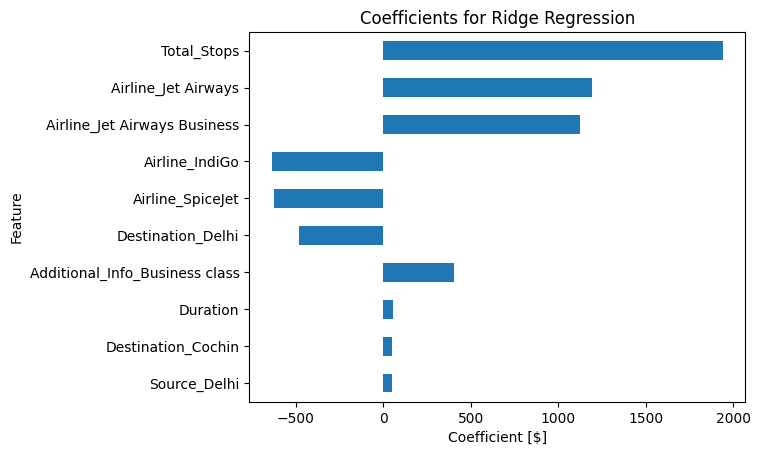

In [52]:
# Plot the top ten coefficients

coefficients = model_ridge.named_steps['ridge'].coef_
feat_imp = pd.Series(coefficients, index=selected_features).sort_values(key=abs)
feat_imp.tail(20).plot(kind='barh')
plt.xlabel('Coefficient [$]')
plt.ylabel('Feature')
plt.title('Coefficients for Ridge Regression');